In [219]:
# import libraries
import torch
import torch.nn as nn
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np

# check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# created date
print("Created date: 2023-06-27 10:39:42")

# modifed date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Modifed date: {now}")
      

PyTorch version: 1.12.1+cu102
Device: cuda
Created date: 2023-06-27 10:39:42
Modifed date: 2023-06-29 15:40:51


#### Dataset

In [121]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [122]:
# view first 5 X values
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [123]:
# view first 5 y values
y[:5]

array([1, 1, 1, 1, 0])

In [124]:
# make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


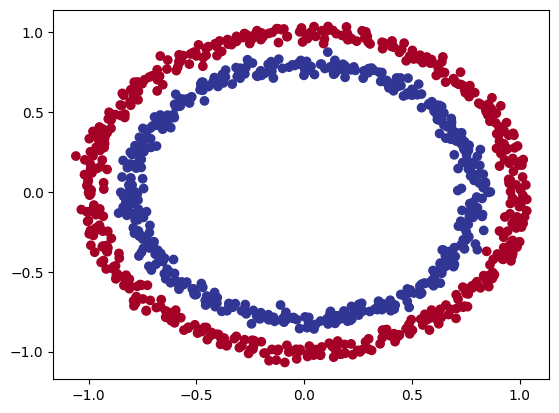

In [125]:
# visualize 
plt.scatter(X[:,0], X[:,1], c = y, cmap=plt.cm.RdYlBu)

Build a PyTorch nn to classify dots in red (0) or blue (1)

#### 1.1 Input and output shapes

In [126]:
# check shapes of features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [127]:
# view the first example of features and labels
feature = X[0]
label = y[0]

print(f" feature: {feature} | shape of feature: {feature.shape}") 
print(f" label: {label} | shape of label: {label.shape}")


 feature: [0.75424625 0.23148074] | shape of feature: (2,)
 label: 1 | shape of label: ()


##### 1.2 Turn data into tensors and create train and test splits

In [128]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [129]:
# view first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [130]:
# 80% training, 20% testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
# check shapes of train set
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [132]:
# check shapes of test set
X_test.shape, y_test.shape

(torch.Size([200, 2]), torch.Size([200]))

#### 2. Building a model

In [133]:
class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # turn 2 features to 5 features =? leading better outputs
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # 5 hidden units or 5 neurons
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    

# create an instance of the model
model_0 = CircleModelV0()

# copy to device
model_0.to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [134]:
# replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

##### 2.1 Setup loss function and optimizer

A regression problem (predicting a number), might use mean absolute error (MAE) loss

A binary classification problem, often use `binary cross entropy` as loss function

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Mutli-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

In [135]:
# loss function
# loss_fn = nn.BCELoss() # no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # sigmoid built-in

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

**torch.eq**

> https://pytorch.org/docs/stable/generated/torch.eq.html

In [136]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # calculate when two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

#### 3. Train model

In [137]:
# view the first 5 outputs of the foward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [138]:
# use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [139]:
# round the prediction probabilities
y_pred = torch.round(y_pred_probs) 

# remove extra dimension
y_pred.squeeze()

tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [140]:
# the first 5 predictions
for i in range(0,5):
    print(f"Prediction: {y_pred.squeeze()[i]} | True value: {y_test[i]}")

Prediction: 0.0 | True value: 1.0
Prediction: 0.0 | True value: 0.0
Prediction: 1.0 | True value: 1.0
Prediction: 0.0 | True value: 0.0
Prediction: 1.0 | True value: 1.0


##### 3.2 Building a traning and testing loop

In [141]:
# set manual seed
torch.manual_seed(42)

# epochs
epochs = 100

# copy data to device
X_train, y_train = X_train.to(device), y_train.to(device)  
X_test, y_test = X_test.to(device), y_test.to(device)  

for epoch in range(epochs):

    ### Training
    # train mode
    model_0.train()

    # forward 
    y_logits  = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # using nn.BCEWLoss
    loss = loss_fn(y_logits, y_train) # using nn.BCEWithLogitsLoss works with raw logits

    # calculate accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # set zero gradients
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # update parameters
    optimizer.step()

    ### Testing
    # eval mode
    model_0.eval()
    with torch.inference_mode():

        # forward pass
        test_logits = model_0(X_test).squeeze()
        # round values
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss
        tess_loss = loss_fn(test_logits, y_test)

        # calculate accuracy
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss: .5f} | accuracy: {acc: .2f} | test loss: {tess_loss: .5f} | accuracy: {test_acc: .2f}")
        
    

Epoch: 0 | loss:  0.69796 | accuracy:  51.88 | test loss:  0.69440 | accuracy:  58.00
Epoch: 10 | loss:  0.69590 | accuracy:  51.25 | test loss:  0.69305 | accuracy:  53.00
Epoch: 20 | loss:  0.69490 | accuracy:  51.62 | test loss:  0.69254 | accuracy:  49.50
Epoch: 30 | loss:  0.69435 | accuracy:  51.12 | test loss:  0.69236 | accuracy:  49.50
Epoch: 40 | loss:  0.69401 | accuracy:  50.88 | test loss:  0.69232 | accuracy:  51.00
Epoch: 50 | loss:  0.69378 | accuracy:  50.25 | test loss:  0.69234 | accuracy:  50.00
Epoch: 60 | loss:  0.69362 | accuracy:  50.00 | test loss:  0.69239 | accuracy:  51.50
Epoch: 70 | loss:  0.69351 | accuracy:  50.25 | test loss:  0.69246 | accuracy:  51.00
Epoch: 80 | loss:  0.69342 | accuracy:  49.88 | test loss:  0.69254 | accuracy:  50.00
Epoch: 90 | loss:  0.69336 | accuracy:  49.88 | test loss:  0.69262 | accuracy:  53.00


#### 4. Make predictions and evaluate the model

> https://madewithml.com/courses/foundations/neural-networks

In [142]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    """
    
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

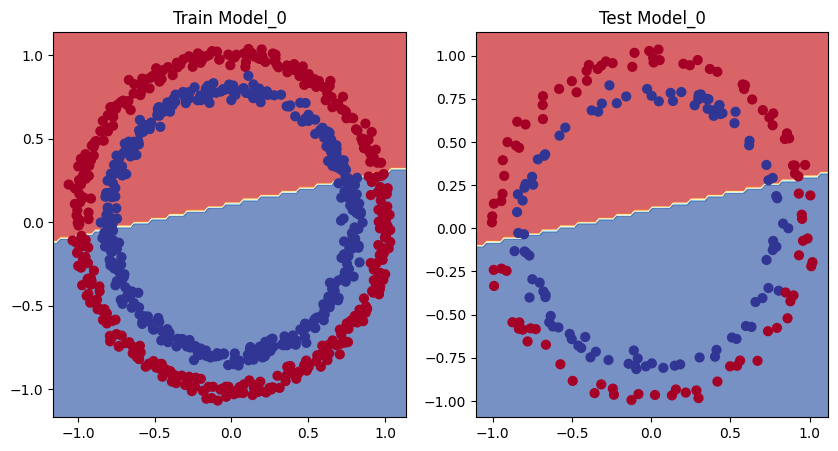

In [143]:
# plot decision boundaries
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Train Model_0")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test Model_0")
plot_decision_boundary(model_0, X_test, y_test)

In [144]:
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # turn 2 features to 5 features =? leading better outputs
        self.layer_1 = nn.Linear(in_features=2, out_features=10) 
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    

# create an instance of the model
model_1 = CircleModelV1()

# copy to device
model_1.to(device)

model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [145]:
# loss_fn = nn.BCELoss() # requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [146]:
# set manual seed
torch.manual_seed(42)

# epochs
epochs = 1000

# copy data to device
X_train, y_train = X_train.to(device), y_train.to(device)  
X_test, y_test = X_test.to(device), y_test.to(device)  

for epoch in range(epochs):

    ### Training
    # train mode
    model_1.train()

    # forward 
    y_logits  = model_1(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # using nn.BCEWLoss
    loss = loss_fn(y_logits, y_train) # using nn.BCEWithLogitsLoss works with raw logits

    # calculate accuracy
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # set zero gradients
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # update parameters
    optimizer.step()

    ### Testing
    # eval mode
    model_1.eval()
    with torch.inference_mode():

        # forward pass
        test_logits = model_1(X_test).squeeze()
        # round values
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate loss
        tess_loss = loss_fn(test_logits, y_test)

        # calculate accuracy
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss: .5f} | accuracy: {acc: .2f} | test loss: {tess_loss: .5f} | accuracy: {test_acc: .2f}")
        

Epoch: 0 | loss:  0.69396 | accuracy:  50.88 | test loss:  0.69261 | accuracy:  51.00
Epoch: 10 | loss:  0.69369 | accuracy:  50.25 | test loss:  0.69270 | accuracy:  50.00
Epoch: 20 | loss:  0.69351 | accuracy:  50.12 | test loss:  0.69283 | accuracy:  49.50
Epoch: 30 | loss:  0.69339 | accuracy:  50.50 | test loss:  0.69297 | accuracy:  48.00
Epoch: 40 | loss:  0.69329 | accuracy:  50.38 | test loss:  0.69310 | accuracy:  49.00
Epoch: 50 | loss:  0.69322 | accuracy:  49.88 | test loss:  0.69324 | accuracy:  50.00
Epoch: 60 | loss:  0.69317 | accuracy:  49.38 | test loss:  0.69336 | accuracy:  51.50
Epoch: 70 | loss:  0.69312 | accuracy:  49.38 | test loss:  0.69348 | accuracy:  50.50
Epoch: 80 | loss:  0.69309 | accuracy:  50.12 | test loss:  0.69359 | accuracy:  50.00
Epoch: 90 | loss:  0.69307 | accuracy:  50.50 | test loss:  0.69370 | accuracy:  48.50
Epoch: 100 | loss:  0.69305 | accuracy:  50.38 | test loss:  0.69379 | accuracy:  48.00
Epoch: 110 | loss:  0.69303 | accuracy:  50

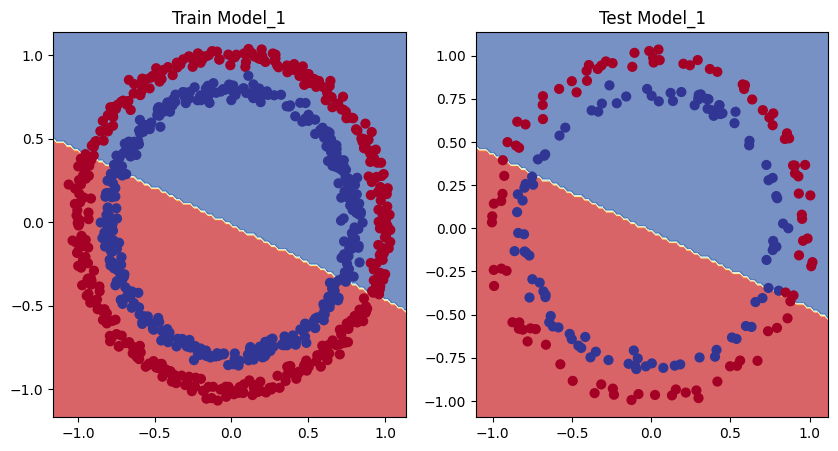

In [147]:
# plot decision boundaries
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Train Model_1")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test Model_1")
plot_decision_boundary(model_1, X_test, y_test)

##### 5.1 Preparing data to see if the model can model a straght line

In [148]:
# create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.001

# create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)

y_regression = weight * X_regression + bias # linear regression formula

In [149]:
# check shapes of X features and labels
X_regression.shape, y_regression.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [150]:
# check len of X features
len(X_regression)

1000

In [151]:
# create train and test sets
train_split = int(0.8*len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

In [152]:
# check shapes of train sets
X_train_regression.shape, y_train_regression.shape

(torch.Size([800, 1]), torch.Size([800, 1]))

In [153]:
# check shapes of test sets
X_test_regression.shape, y_test_regression.shape

(torch.Size([200, 1]), torch.Size([200, 1]))

In [154]:
def plot_prediction(train_data= X_train_regression, 
                    train_labels=y_train_regression,
                    test_data= X_test_regression,
                    test_labels = y_test_regression, predictions = None):
    
    """
    Plot training, testing data
    """
    plt.figure(figsize=(10,5))

    # plot training set in red
    plt.scatter(train_data, train_labels, c="r", s = 5, label="Training set")

    # plot testing set in red
    plt.scatter(test_data, test_labels, c="b", s = 5, label="Testing set")

    # plot predictions in green
    if predictions is not None:
        plt.scatter(test_data, predictions, c="g", s = 5, label="Predictions")

    plt.legend()

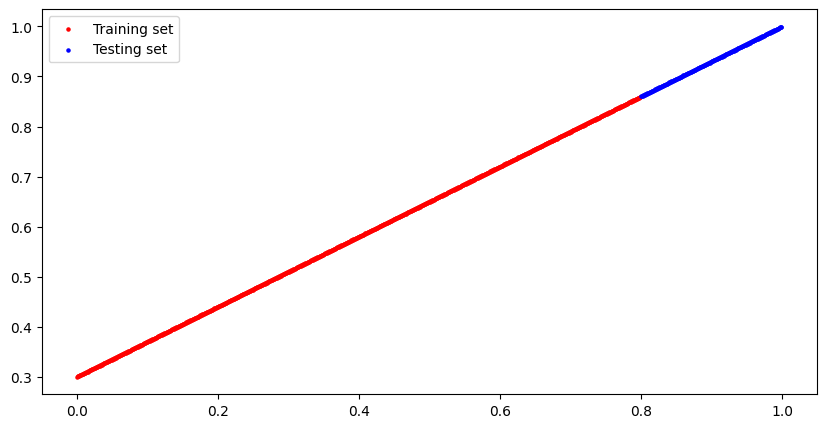

In [155]:
# visual dataset
plot_prediction()

##### 5.2. Adjusting model_1 to fit a straight line

In [156]:
X_train_regression.shape, y_train_regression.shape

(torch.Size([800, 1]), torch.Size([800, 1]))

In [157]:
X_test_regression.shape, y_test_regression.shape

(torch.Size([200, 1]), torch.Size([200, 1]))

In [158]:
# set manual seed
torch.manual_seed(42)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [159]:
# loss function
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [160]:
# num epochs 
epochs = 200

# copy data to device
# train set
X_train_regression_gpu = X_train_regression.to(device)
y_train_regression_gpu = y_train_regression.to(device)

# test set
X_test_regression_gpu = X_test_regression.to(device)
y_test_regression_gpu = y_test_regression.to(device)

for epoch in range(epochs):

    ### TRAINING 

    # train mode
    model_2.train()

    # forward pass
    y_pred = model_2(X_train_regression_gpu)

    # calculate loss
    loss = loss_fn(y_pred, y_train_regression_gpu)

    # set zero gradients
    optimizer.zero_grad()

    # backward propagration
    loss.backward()

    # update parameters
    optimizer.step()

    
    ### TESTING

    # eval mode
    model_2.eval()
    with torch.inference_mode():
        
        # forward pass
        y_test_pred = model_2(X_test_regression_gpu)

        # calculate loss
        test_loss = loss_fn(y_test_pred, y_test_regression_gpu)

    # print out
    print(f"Epoch: {epoch}/{epochs} | MAE loss: {loss: .5f} | MAE test loss: {test_loss: .5f}")


Epoch: 0/200 | MAE loss:  0.76161 | MAE test loss:  0.95138
Epoch: 1/200 | MAE loss:  0.75780 | MAE test loss:  0.94706
Epoch: 2/200 | MAE loss:  0.75400 | MAE test loss:  0.94274
Epoch: 3/200 | MAE loss:  0.75020 | MAE test loss:  0.93844
Epoch: 4/200 | MAE loss:  0.74641 | MAE test loss:  0.93413
Epoch: 5/200 | MAE loss:  0.74263 | MAE test loss:  0.92984
Epoch: 6/200 | MAE loss:  0.73885 | MAE test loss:  0.92555
Epoch: 7/200 | MAE loss:  0.73508 | MAE test loss:  0.92126
Epoch: 8/200 | MAE loss:  0.73132 | MAE test loss:  0.91698
Epoch: 9/200 | MAE loss:  0.72756 | MAE test loss:  0.91271
Epoch: 10/200 | MAE loss:  0.72381 | MAE test loss:  0.90844
Epoch: 11/200 | MAE loss:  0.72006 | MAE test loss:  0.90418
Epoch: 12/200 | MAE loss:  0.71632 | MAE test loss:  0.89993
Epoch: 13/200 | MAE loss:  0.71259 | MAE test loss:  0.89568
Epoch: 14/200 | MAE loss:  0.70886 | MAE test loss:  0.89143
Epoch: 15/200 | MAE loss:  0.70513 | MAE test loss:  0.88719
Epoch: 16/200 | MAE loss:  0.70142

In [161]:
# evaluation
predictions = model_2(X_test_regression_gpu)

predictions_cpu = predictions.cpu()

In [162]:
predictions.cpu().detach()[0] # detach gradient

tensor([0.7395])

In [163]:
predictions.cpu()[0]

tensor([0.7395], grad_fn=<SelectBackward0>)

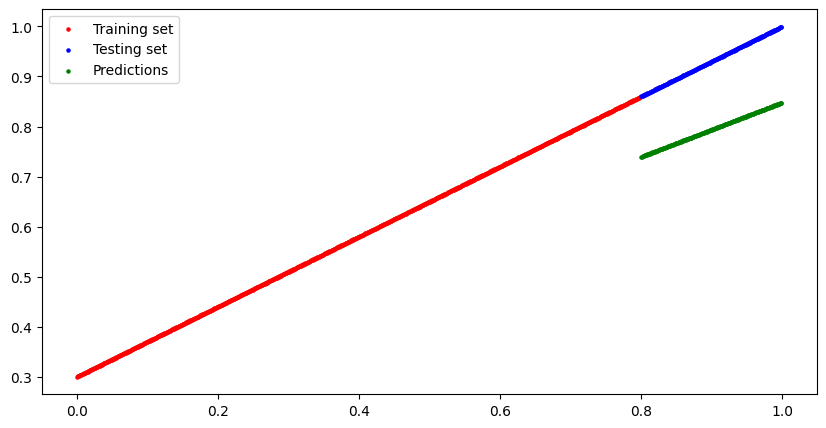

In [164]:
# visualize 
plot_prediction(predictions=predictions.cpu().detach().numpy())

#### 6. The missing piece: non-linearity

##### 6.1. Recreating non-linear data (red and blue circles)

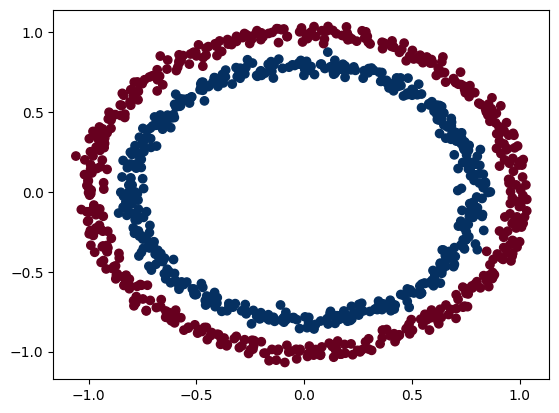

In [180]:
# make and plot data
n_samples = 1000

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)

In [181]:
# convert to tensors and split into train and test sets

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test sets
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [182]:
# check shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

##### 6.2. Building a model with non-linearity

**Non-linear Activations**
> https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [204]:
# build model with non-linear activation function
class CircleModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [205]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

##### 6.3. Training a model with non-linearity

In [206]:
def accuracy_fn(y_labels, y_predictions):
    correct = torch.eq(y_labels, y_predictions).sum().item()
    acc = (correct / len(y_predictions)) * 100
    return acc

In [207]:
# set manual seed
torch.manual_seed(42)

# epochs
epochs = 1000

# copy data to device
X_train_gpu = X_train.to(device)
X_test_gpu = X_test.to(device)
y_train_gpu = y_train.to(device)
y_test_gpu = y_test.to(device)

for epoch in range(epochs):

    ### TRAINING
    
    # train mode
    model_3.train()

    # forward pass
    y_logits = model_3(X_train_gpu).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss
    loss = loss_fn(y_logits, y_train_gpu)
    acc = accuracy_fn(y_labels=y_train_gpu, y_predictions=y_pred)

    # set zero gradient
    optimizer.zero_grad()

    # backward propagration
    loss.backward()

    # update parameters with step()
    optimizer.step()


    ### TESTING

    # test mode
    model_3.eval()
    with torch.inference_mode():

        # forward pass
        y_test_logits = model_3(X_test_gpu).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))

        # calculate loss
        test_loss = loss_fn(y_test_logits,y_test_gpu)

        # calculate acc
        test_acc = accuracy_fn(y_labels=y_test_gpu, y_predictions=y_test_pred)
        
    # print out
    print(f"Epoch: {epoch}/{epochs} | loss: {loss:0.5f} | accuracy: {acc:0.2f} | test_loss: {test_loss:0.5f} | test accuracy: {test_acc:0.2f}")

Epoch: 0/1000 | loss: 0.69441 | accuracy: 50.00 | test_loss: 0.69371 | test accuracy: 50.00
Epoch: 1/1000 | loss: 0.69440 | accuracy: 50.00 | test_loss: 0.69370 | test accuracy: 50.00
Epoch: 2/1000 | loss: 0.69438 | accuracy: 50.00 | test_loss: 0.69369 | test accuracy: 50.00
Epoch: 3/1000 | loss: 0.69437 | accuracy: 50.00 | test_loss: 0.69367 | test accuracy: 50.00
Epoch: 4/1000 | loss: 0.69436 | accuracy: 50.00 | test_loss: 0.69366 | test accuracy: 50.00
Epoch: 5/1000 | loss: 0.69435 | accuracy: 50.00 | test_loss: 0.69365 | test accuracy: 50.00
Epoch: 6/1000 | loss: 0.69433 | accuracy: 50.00 | test_loss: 0.69364 | test accuracy: 50.00
Epoch: 7/1000 | loss: 0.69432 | accuracy: 50.00 | test_loss: 0.69362 | test accuracy: 50.00
Epoch: 8/1000 | loss: 0.69431 | accuracy: 50.00 | test_loss: 0.69361 | test accuracy: 50.00
Epoch: 9/1000 | loss: 0.69430 | accuracy: 50.00 | test_loss: 0.69360 | test accuracy: 50.00
Epoch: 10/1000 | loss: 0.69429 | accuracy: 50.00 | test_loss: 0.69359 | test acc

##### 6.4 Evaluating a model 

In [208]:
# predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test_gpu))).squeeze()

y_preds.shape

torch.Size([200])

In [209]:
# print out
y_preds[:10], y_test_gpu[:10]

(tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

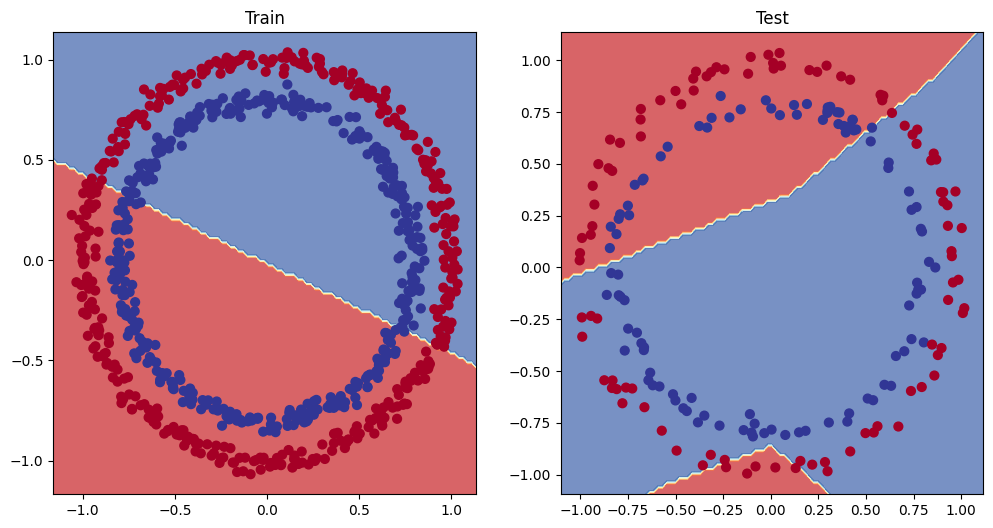

In [210]:
# plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

#### 7. Replicating non-linear activation functions

In [212]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

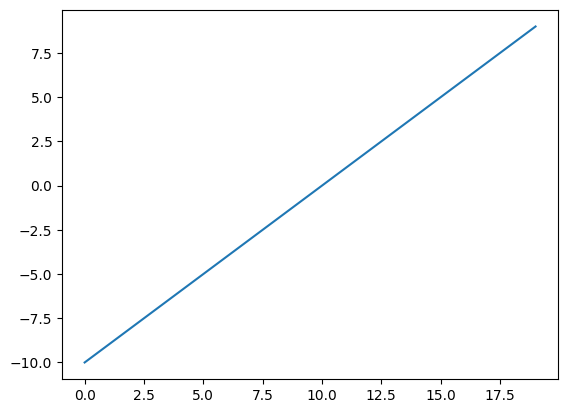

In [213]:
# visual the tensor
plt.plot(A)

In [215]:
# create ReLU function
def relu(x):
    return torch.maximum(torch.tensor(0), x) # if x < 0: 0: x

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

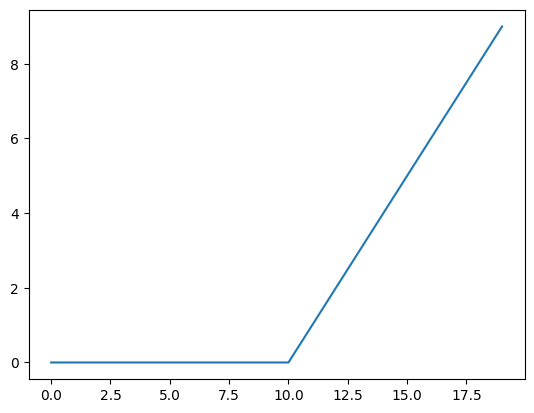

In [216]:
# plot relu(A)
plt.plot(relu(A))

In [217]:
# a sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# test the tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

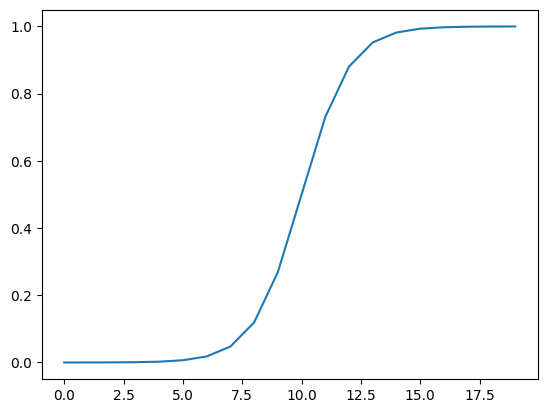

In [218]:
# plot sigmod(A)
plt.plot(sigmoid(A))

#### 8. Putting things together by building a multi-class PyTorch model

##### 8.1. Creating multi-classification data

In [220]:
# set the hyperparameters for data creation
N_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# multi-class data
X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [221]:
# view data
X_blob[:5]

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]])

In [222]:
# view data
y_blob[:5]

tensor([3, 2, 2, 1, 1])

In [223]:
# split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

In [224]:
# check shapes
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [225]:
# check shapes
X_blob_test.shape, y_blob_test.shape 

(torch.Size([200, 2]), torch.Size([200]))

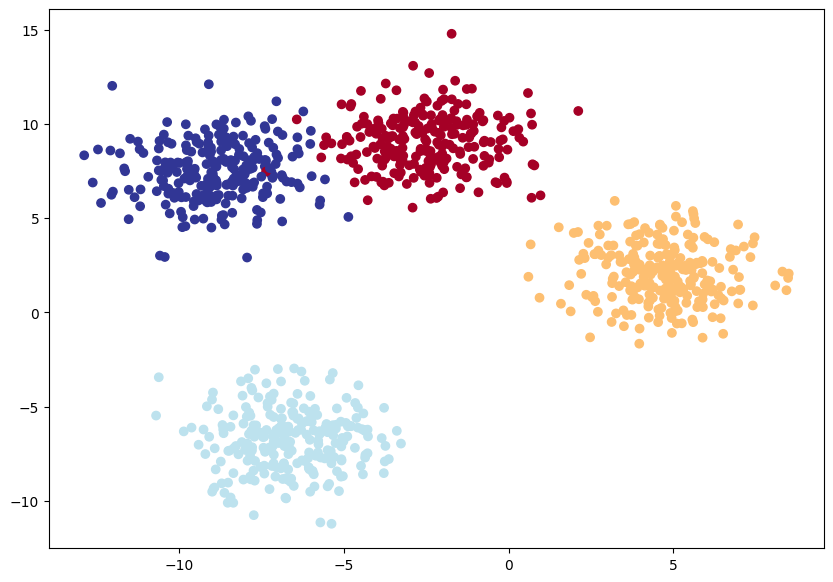

In [226]:
# plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

##### 8.2 Building a multi-class classification model in PyTorch

In [227]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),  
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

##### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [269]:
# due to working with multi-class classification, use `nn.CrossEntropyLoss()` method
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

##### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [228]:
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [230]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [231]:
# prediction logits
y_logits = model_4(X_blob_test.to(device))

In [233]:
# view logits
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [232]:
# check shape
y_logits.shape

torch.Size([200, 4])

In [253]:

# perform softmax calculation 
y_pred_probs = torch.softmax(y_logits, dim=1)

In [256]:
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [257]:
y_pred_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [258]:
torch.sum(y_pred_probs[0]) # total of all classes should be 1

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [261]:
y_pred_probs[0]

tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [263]:
torch.argmax(y_pred_probs[0]) # most likely class value is 3

tensor(1, device='cuda:0')

a model's raw output is referred to as **logits**.

##### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [270]:
# set manual seed
torch.manual_seed(42)

# num of epochs
epochs = 100

# copy data to device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    ### TRAINING

    # train mode
    model_4.train()

    # forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction labels

    # calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)

    # accuracy 
    acc = accuracy_fn(y_blob_train, y_pred)

    # set zero gradients
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # update parameters
    optimizer.step()


    ### TESTING

    # eval mode
    model_4.eval()
    with torch.inference_mode():

        # forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)

        test_acc = accuracy_fn(y_blob_test, test_pred)

    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


#####  8.6 Making and evaluating predictions with a PyTorch multi-class model

In [271]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# view the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [273]:
# turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_blob_test, y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


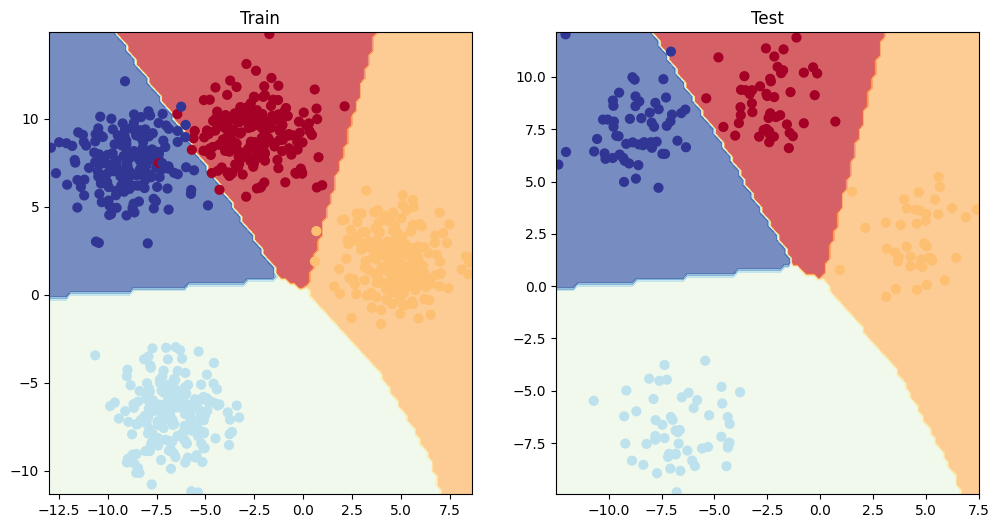

In [274]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

#### 9. More classification evaluation metrics

In [278]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy


# setup metric
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')